In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import pandas as pd
import torch

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn_vision_resnet/'

# Reconstruction Training

In [3]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

In [4]:
tensorboard_dir = f'{engram_dir}tensorboard/'

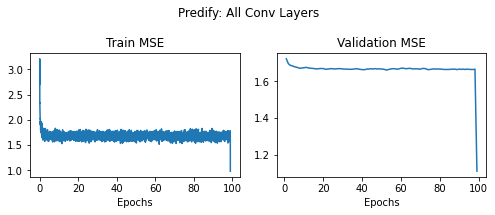

In [10]:
tfdir = tensorboard_dir + 'pnet_magshuffle/'
tfdir_files = os.listdir(tfdir)
tffiles = [tfdir + f for f in tfdir_files]
tffiles.sort(key=os.path.getctime)
train_loss = []
eval_loss = []

for tffile in tffiles:
    #print('Showing:')
    #print(tffile)
    ea = event_accumulator.EventAccumulator(tffile)
    ea.Reload()

    train_loss.extend([e.value for e in ea.Scalars('MSE Train/Sum')])
    eval_loss.extend([e.value for e in ea.Scalars('MSE Test/Sum')])
    
fig, axs = plt.subplots(1, 2, figsize = (7, 3))   
smoothed_train = smooth(
    np.linspace(0, len(eval_loss), len(train_loss)), train_loss, n=5)
axs[0].plot(
    np.linspace(0, len(eval_loss), len(train_loss))[1:],
    smoothed_train[1:])
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
smoothed_eval = smooth(
    np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss, n=3)
axs[1].plot(
    np.linspace(0, len(eval_loss), len(eval_loss))[1:],
    smoothed_eval[1:])
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')

plt.suptitle('Predify: All Conv Layers')
plt.tight_layout()
plt.show()

# Plot hyperparameters

In [6]:
plot_ci = True

In [7]:
def plot_hps(netname):
    tensorboard_dir = f'{engram_dir}hyperparams/{netname}/'
    for tfdir in os.listdir(tensorboard_dir):
        # Collect tensorboard files of interest
        if tfdir.startswith('.'): continue
        print(tfdir)
        tfdir = tensorboard_dir + tfdir + '/'
        tfdir_files = os.listdir(tfdir)
        if not plot_ci:
            if len(tfdir_files) > 1:
                print('More than one TF file; check it is correct.')
            tfdir_files = [tfdir_files[0]]

        # Collect losses
        for tfdir_file in tfdir_files:
            train_loss = []
            train_batch = []
            eval_loss = []
            eval_epoch = []
            eval_timestep = []
            tf_file = tfdir + tfdir_file
            if tfdir_file.endswith('.p'):
                with open(tf_file, 'rb') as f:
                    results = pickle.load(f)
                for res_string in results:
                    if res_string[0] == 'TrainingLoss/CE':
                        train_loss.append(res_string[1])
                        train_batch.append(res_string[2])
                    elif res_string[0].startswith('NoisyPerf'):
                        _eval_epoch = int(res_string[0].split(
                            'NoisyPerf/Epoch#')[-1])
                        eval_loss.append(res_string[1])
                        eval_epoch.append(_eval_epoch)
                        eval_timestep.append(res_string[2])
            elif tfdir_file.startswith('events'):
                ea = event_accumulator.EventAccumulator(tf_file)
                ea.Reload()
                _train_loss = [e.value for e in ea.Scalars('TrainingLoss/CE')]
                _train_batch = [i for i in range(len(_train_loss))]
                _train_loss = smooth(_train_batch, _train_loss, 1000)
                train_loss.extend(_train_loss)
                train_batch.extend(_train_batch)
                epoch = 1
                while True:
                    try:
                        for timestep in range(5):
                            eval_loss.append(
                                ea.Scalars(f'NoisyPerf/Epoch#{epoch}')[timestep].value)
                            eval_epoch.append(epoch)
                            eval_timestep.append(timestep)
                        epoch += 1
                    except:
                        break
            else:
                continue

            # Make pandas dataframe
            train_df = pd.DataFrame({
                'Train Loss': train_loss,
                'Batch': train_batch
                })
            eval_df = pd.DataFrame({
                'Eval Accuracy': eval_loss,
                'Epoch': eval_epoch,
                'Timestep': eval_timestep 
                })

            fig, axs = plt.subplots(1, 2, figsize = (8,3))
            sns.lineplot(x='Batch', y='Train Loss', ax=axs[0], data=train_df)
            colors = plt.cm.cool(np.linspace(0,1,5))
            for timestep in range(5):
                sns.lineplot(
                    x='Epoch', y='Eval Accuracy', ax=axs[1],
                    data=eval_df[eval_df['Timestep']==timestep],
                    color=colors[timestep], label=timestep, alpha=0.7)
            plt.tight_layout()
            axs[0].set_title(tfdir_file)
            axs[1].set_title(tfdir_file)
            plt.show()

gaussian_noise_lvl_3


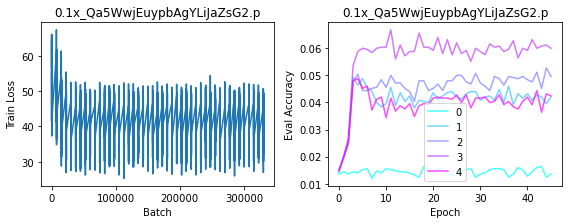

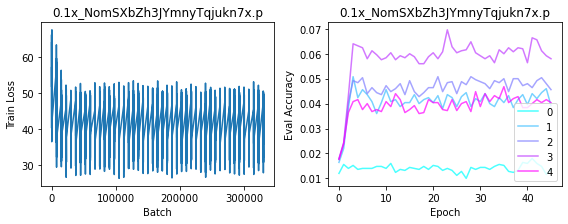

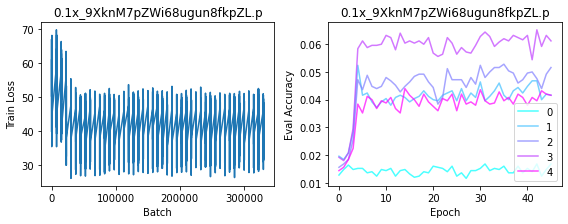

none_lvl_1


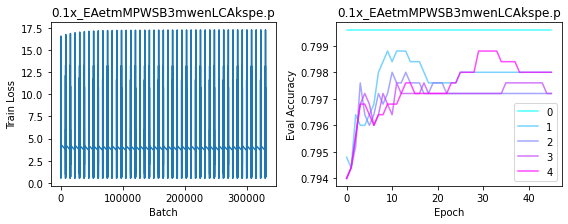

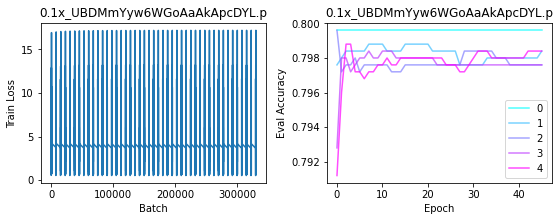

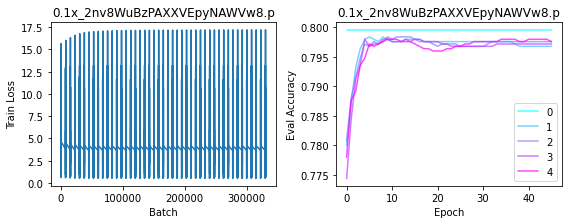

impulse_noise_lvl_1


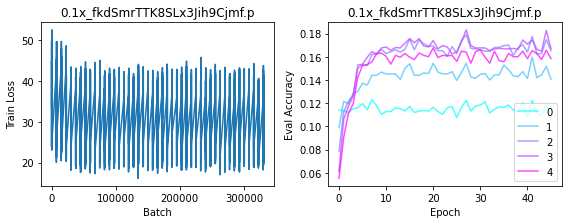

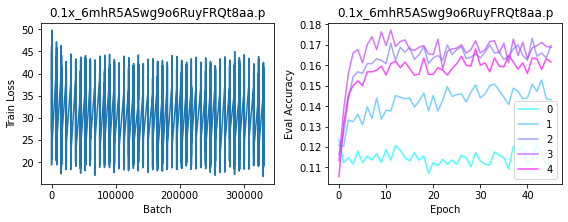

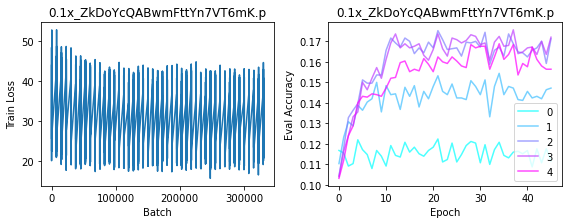

impulse_noise_lvl_2


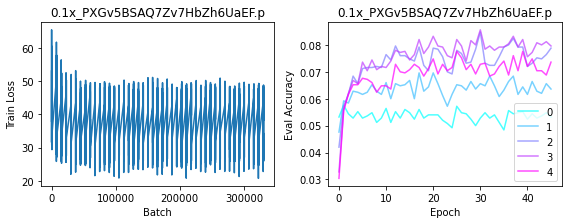

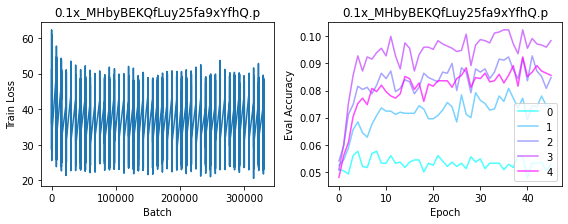

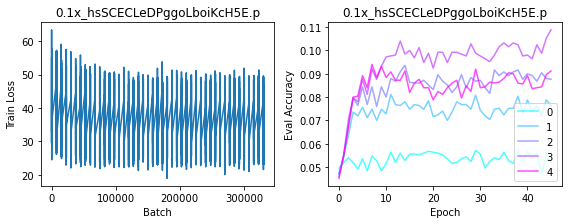

gaussian_noise_lvl_1


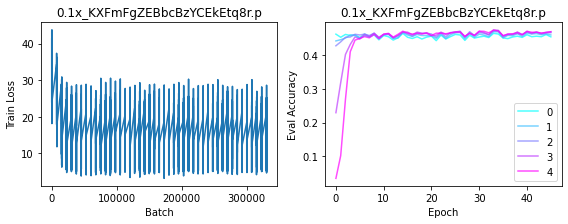

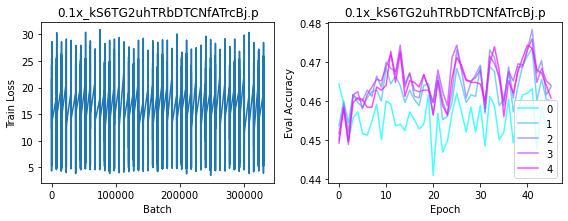

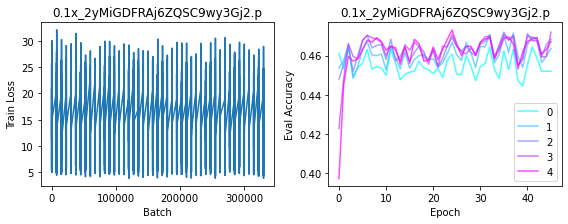

gaussian_noise_lvl_2


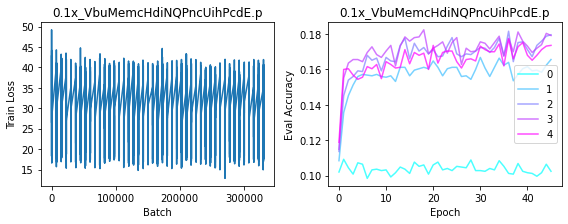

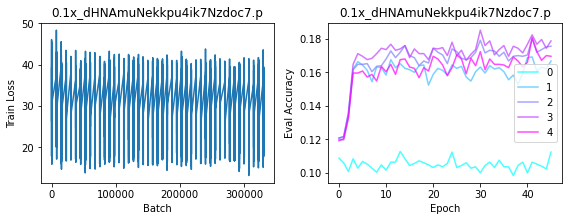

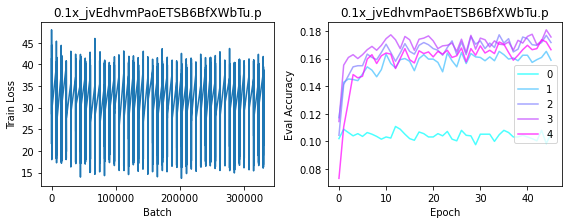

impulse_noise_lvl_3


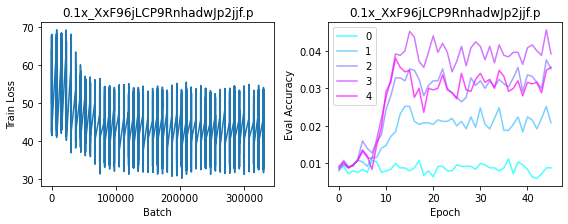

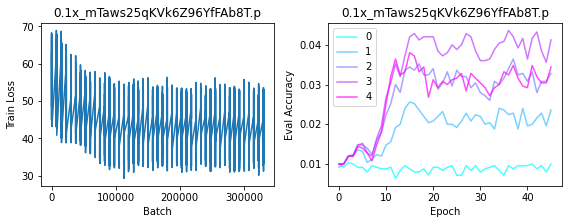

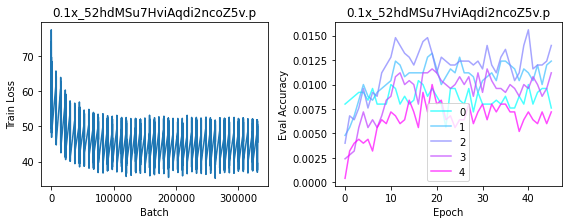

In [8]:
plot_hps('pnet')